# Import Libraries

In [79]:
import matplotlib.pyplot as plt
import warnings
import time,sys
import copy

import pandas as pd
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import pathlib
import shutil
from pathlib import Path
from collections import Counter
!pip install torchsummary
from torchsummary import summary

!pip install torchviz
from torchviz import make_dot, make_dot_from_trace

warnings.filterwarnings('ignore')
torch.manual_seed(0)

# Mounting Drive

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Creation

In [119]:
!gdown --id 10TbLFo2cgcmlNjgQMZeiI_D68StH5gfW

Downloading...
From: https://drive.google.com/uc?id=10TbLFo2cgcmlNjgQMZeiI_D68StH5gfW
To: /content/Dataset C.zip
162MB [00:00, 168MB/s]


In [120]:
!unzip '/content/Dataset C.zip'

Archive:  /content/Dataset C.zip
replace training-c/c00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load dataset from drive

In [121]:
training_csv = "/content/training-c.csv"
read_df = pd.read_csv(training_csv)

read_df.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [122]:
number_of_digit_class = 10
for i in range(0,number_of_digit_class):
  select_digit = read_df[read_df['digit'] == i]
  print(i , select_digit.shape )

0 (2438, 7)
1 (2403, 7)
2 (2437, 7)
3 (2438, 7)
4 (2446, 7)
5 (2444, 7)
6 (2442, 7)
7 (2445, 7)
8 (2400, 7)
9 (2405, 7)


## Store into digit based folders

In [123]:
number_of_digit_class = read_df['digit'].nunique()

DATASET_ROOT_DIR = './PROCESSED_DATASET_170104019/' 
path = Path(DATASET_ROOT_DIR)
path.mkdir(parents=True, exist_ok=True)
DATASET_ROOT_DIR = os.path.abspath(path)

for i in range(0,number_of_digit_class):
  select_digit = read_df[read_df['digit'] == i]
  for index,val in select_digit.iterrows():
    file_relative_path_from= f"./{val['database name']}/{val['filename']}"
    file_relative_dir_to = f"{DATASET_ROOT_DIR}/{val['digit']}"
    Path(file_relative_dir_to).mkdir(parents=True, exist_ok=True)
    shutil.copy(file_relative_path_from, file_relative_dir_to)
    print(file_relative_path_from , file_relative_dir_to , "OK")

Streaming output truncated to the last 5000 lines.
./training-c/c22339.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22368.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22403.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22404.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22415.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22423.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22435.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22456.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22462.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22477.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22488.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22497.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22513.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22517.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22524.png /

## Variable Declaration

In [124]:
base_dir = '/content/PROCESSED_DATASET_170104019' 
BATCH_SIZE = 32


IMAGE_SIZE = 28
LEARNING_RATE = 0.01
TEST_SIZE = 0.2
OUTPUT_DIM=10

## Load Dataset

In [125]:
transform = transforms.Compose([
                                transforms.Grayscale(),
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE), ## image center crop
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                               ])

#load training dataset 
dataset = torchvision.datasets.ImageFolder(base_dir, transform=transform)
n = len(dataset) 
n_test = int(TEST_SIZE * n) # 10% validation
trainDataset, validDataSet = torch.utils.data.random_split(dataset,[n - n_test,n_test]) #random split dataset
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,) 
validationloader = torch.utils.data.DataLoader(validDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,) 
print("Length of the trainloader:", len(trainloader ) * BATCH_SIZE)
print("Length of the validationloader:", len(validationloader ) * BATCH_SIZE)

Length of the trainloader: 19456
Length of the validationloader: 4864


In [126]:

# trainDataset = torchvision.datasets.FashionMNIST(root='./data', 
#                             train=True, 
#                             transform=transforms.ToTensor(),  # Normalize the image to [0-1] from [0-255]
#                             download=True)

# validDataSet = torchvision.datasets.FashionMNIST(root='./data', 
#                            train=False, 
#                            transform=transforms.ToTensor())

# '''
# MAKING DATASET ITERABLE
# '''

# trainloader = torch.utils.data.DataLoader(dataset=trainDataset, 
#                                            batch_size=BATCH_SIZE, 
#                                            shuffle=True)   # It's better to shuffle the whole training dataset! 

# validationloader = torch.utils.data.DataLoader(dataset=validDataSet, 
#                                           batch_size=BATCH_SIZE, 
#                                           shuffle=False)  

# print("Length of the trainloader:", len(trainloader ) * BATCH_SIZE)
# print("Length of the validationloader:", len(validationloader ) * BATCH_SIZE)

## Explore Dataset

In [127]:
dataset.class_to_idx # class map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [128]:
print(dict(Counter(dataset.targets))) # count number of data in a class

{0: 2438, 1: 2403, 2: 2437, 3: 2438, 4: 2446, 5: 2444, 6: 2442, 7: 2445, 8: 2400, 9: 2405}


In [129]:
train_classes = [label for _, label in trainDataset]
print(dict(Counter(train_classes)))

{1: 1931, 5: 1940, 2: 1954, 3: 1981, 7: 1978, 4: 1941, 8: 1913, 6: 1953, 9: 1925, 0: 1923}


In [130]:
val_classes = [label for _, label in validDataSet]
print(dict(Counter(val_classes)))

{2: 483, 6: 489, 0: 515, 9: 480, 4: 505, 1: 472, 3: 457, 7: 467, 8: 487, 5: 504}


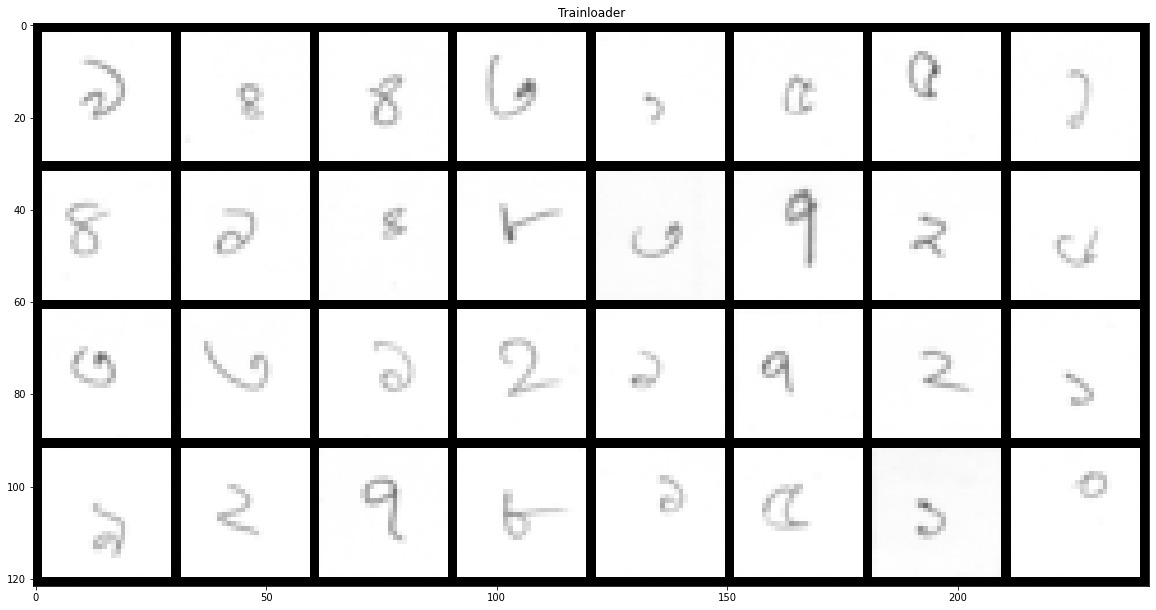

tensor([9, 4, 4, 3, 1, 5, 5, 1, 4, 1, 4, 8, 3, 7, 2, 6, 3, 3, 1, 2, 1, 7, 2, 1,
        9, 2, 7, 8, 1, 5, 1, 0])


In [131]:
for image,label in trainloader:
  plt.figure(figsize=(20,20))
  grid_imge_gen = torchvision.utils.make_grid(image)
  plt.imshow(grid_imge_gen.permute(1, 2, 0).cpu())
  plt.title("Trainloader")
  plt.show()
  print(label)
  break

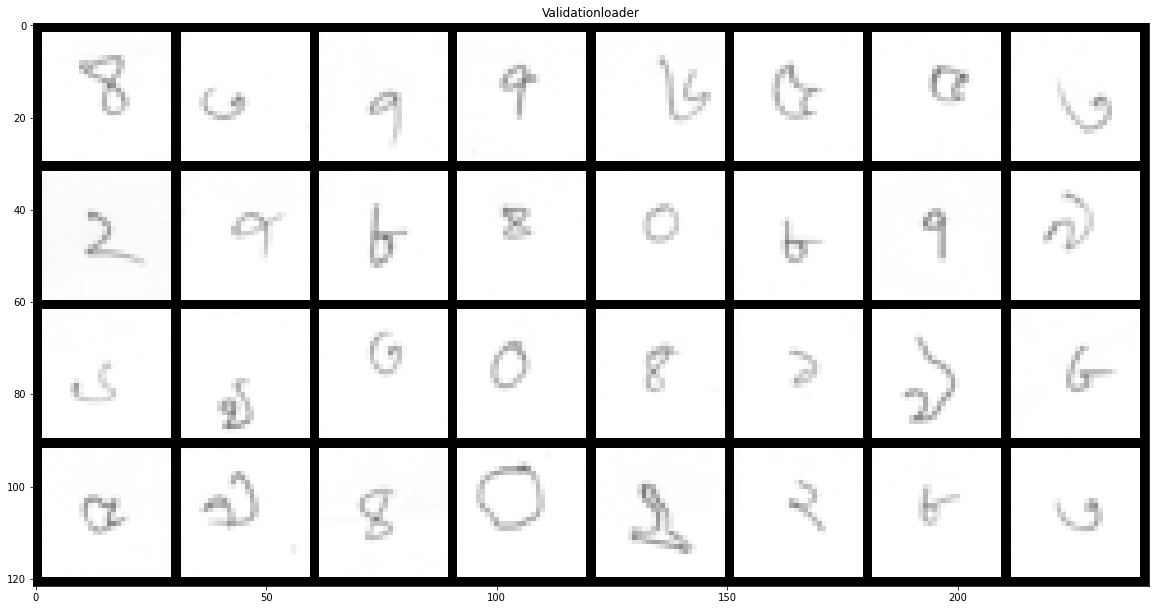

tensor([4, 3, 7, 7, 6, 5, 5, 3, 2, 7, 8, 4, 0, 8, 7, 9, 6, 9, 3, 0, 4, 1, 9, 8,
        5, 9, 4, 0, 2, 2, 8, 3])


In [132]:
for image,label in validationloader:
  plt.figure(figsize=(20,20))
  grid_imge_gen = torchvision.utils.make_grid(image)
  plt.imshow(grid_imge_gen.permute(1, 2, 0).cpu())
  plt.title("Validationloader")
  plt.show()
  print(label)
  break

# Model

In [133]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1st Try

In [134]:
class LIN_MODEL_2(torch.nn.Module): 
    def __init__(self,outDim):
        super(LIN_MODEL_2, self).__init__()

        self.fc_1 = torch.nn.Linear(784, 742)
        self.fc_2 = torch.nn.Linear(742, 621)
        self.fc_3 = torch.nn.Linear(621, 510)
        self.fc_6 = torch.nn.Linear(510, outDim)
 
    def forward(self, x):

        x = x.view(-1, 28 * 28) 
        x = torch.nn.functional.relu(self.fc_1(x))
        x = torch.nn.functional.relu(self.fc_2(x))
        x = torch.nn.functional.relu(self.fc_3(x))
        x = torch.nn.functional.relu(self.fc_6(x))

        return x
        
model_1_2 = LIN_MODEL_2(OUTPUT_DIM).to(device)

summary( model_1_2, input_size=(1, 28, 28))
# select CPU or GPU as a device
print(model_1_2)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 742]         582,470
            Linear-2                  [-1, 621]         461,403
            Linear-3                  [-1, 510]         317,220
            Linear-4                   [-1, 10]           5,110
Total params: 1,366,203
Trainable params: 1,366,203
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 5.21
Estimated Total Size (MB): 5.23
----------------------------------------------------------------
LIN_MODEL_2(
  (fc_1): Linear(in_features=784, out_features=742, bias=True)
  (fc_2): Linear(in_features=742, out_features=621, bias=True)
  (fc_3): Linear(in_features=621, out_features=510, bias=True)
  (fc_6): Linear(in_features=510, out_features=10, bias=True)
)


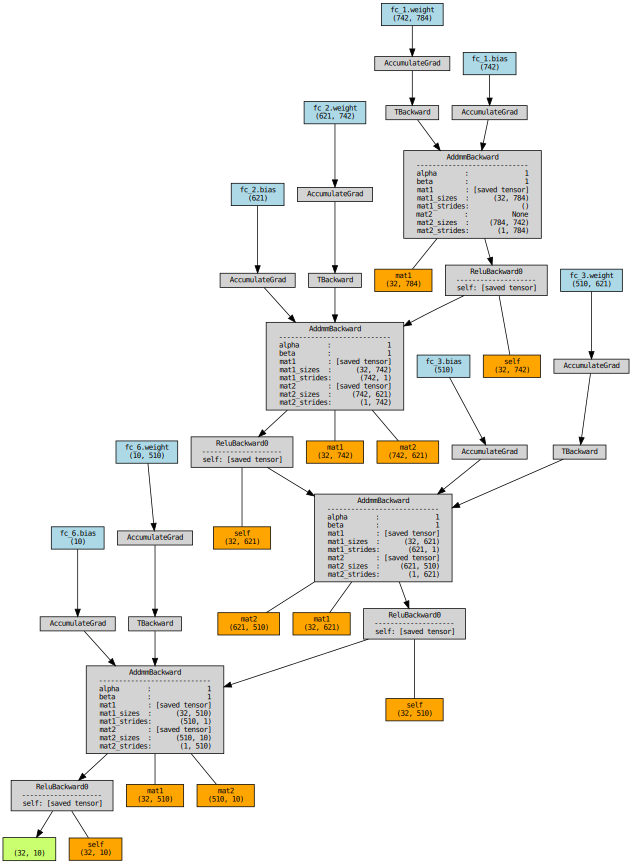

In [135]:
x = torch.randn(BATCH_SIZE,1,28,28).to(device)
make_dot(model_1_2(x), params=dict(model_1_2.named_parameters()), show_attrs=True, show_saved=True)

In [136]:
make_dot(model_1_2(x), params=dict(model_1_2.named_parameters()), show_attrs=True, show_saved=True).render("Model-1-2", format="png")

'Model-1-2.png'

In [137]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1_2.parameters(),lr=LEARNING_RATE, )

## 2nd Try

In [96]:
class LIN_MODEL_3(torch.nn.Module): 
    def __init__(self,outDim):
        super(LIN_MODEL_3, self).__init__()

        self.fc_1 = torch.nn.Linear(784, 512)
        self.fc_2 = torch.nn.Linear(512, 256)
        self.fc_6 = torch.nn.Linear(256, outDim)
 
    def forward(self, x):

        x = x.view(-1, 28 * 28) 
        x = torch.nn.functional.relu(self.fc_1(x))
        x = torch.nn.functional.relu(self.fc_2(x))
        x = torch.nn.functional.relu(self.fc_6(x))

        return x
        
model_1_3 = LIN_MODEL_3(OUTPUT_DIM).to(device)

summary( model_1_3, input_size=(1, 28, 28))
print(model_1_3)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.04
Estimated Total Size (MB): 2.05
----------------------------------------------------------------
LIN_MODEL_3(
  (fc_1): Linear(in_features=784, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=256, bias=True)
  (fc_6): Linear(in_features=256, out_features=10, bias=True)
)


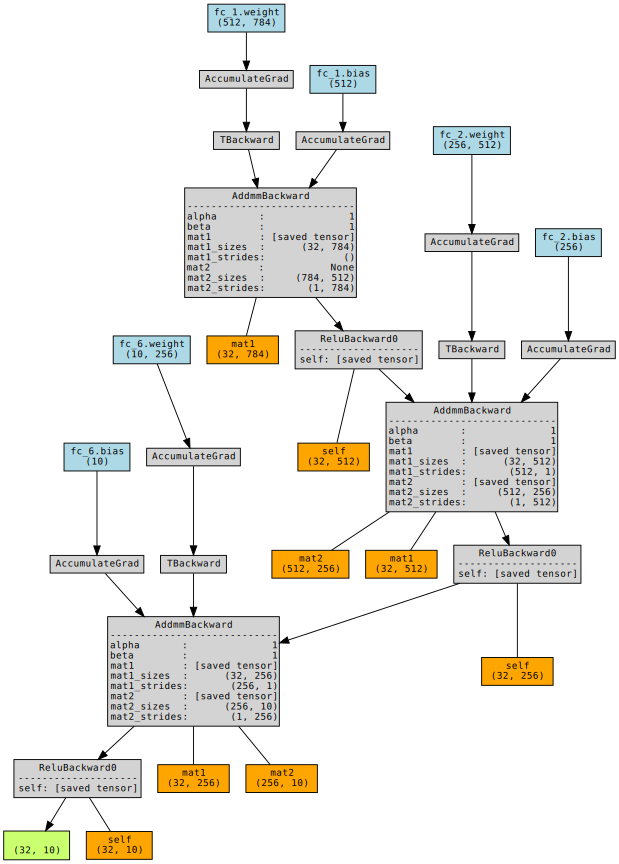

In [97]:
x = torch.randn(32,1,28,28).to(device)
make_dot(model_1_3(x), params=dict(model_1_3.named_parameters()), show_attrs=True, show_saved=True)

In [98]:
make_dot(model_1_3(x), params=dict(model_1_3.named_parameters()), show_attrs=True, show_saved=True).render("Model-1-3", format="png")

'Model-1-3.png'

In [99]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1_3.parameters(),lr=LEARNING_RATE, )

# Training

## Save Model

In [138]:
def save_model(
               MODEL_USED,
               SAVEPATH,
               epoch, 
               batch_size, 
               model,
               optimizer,
               image_size,
               tranning_loss=[],
               tranning_acc=[],
               validation_loss=[],
               validation_acc=[],
               learning_rate=0.001,
               meta_data=None):
  SAVEPATH += f"{MODEL_USED}-checkpoint-epoch-{epoch}.pt"
  save_obj = {
       'MODEL_USED':MODEL_USED,
       'batch_size':batch_size,
       'epoch': epoch,
       'model_full': model,
       'optimizer_full': optimizer,
       'model_state': model.state_dict(),
       'optimizer_state': optimizer.state_dict(),
       'image_size': image_size,
       'tranning_loss': tranning_loss,
       'tranning_acc': tranning_acc,
       'validation_loss': validation_loss,
       'validation_acc': validation_acc,
       'learning_rate':learning_rate,
       'meta_data':meta_data
       }

  torch.save(save_obj, SAVEPATH)

## Train Function

In [139]:
def train_model(start, end, 
                model_used ,
                model_save_path, 
                model, 
                criterion, 
                optimizer, 
                dataloaders,
                testloaders , 
                lernRate=0.001,
                all_tranning_loss=[], all_validation_loss=[], all_tranning_accuracy=[], all_validation_accuracy=[]):
    since = time.time()
    num_epochs = end
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    phase = 'train'
    steps = 0

    for epoch in range(start,num_epochs):
          model.train()
          phase = 'tranning'
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)
          running_loss = 0.0
          running_corrects = 0

          for i,(inputs, labels) in enumerate(dataloaders):
                
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                # running_loss += loss.item() * inputs.size(0)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                

                print_val = f"Epoch: {epoch}/{num_epochs-1} Steps {steps} \t"
                print_val += f"running_loss : {(loss.item()):.6f}\t"
                print_val += f"running_corrects : {torch.sum(preds == labels.data)}\t"  
                print_val += f"total_corrects : {running_corrects}\t"  
                sys.stdout.write('\r' + str(print_val))
                steps += 1
          
          
          steps = 0
          epoch_loss = running_loss / len(dataloaders)
          epoch_acc = running_corrects.double().item() /len(dataloaders.dataset)
          all_tranning_loss.append(loss.item())
          all_tranning_accuracy.append(epoch_acc)
          
          
          print("\n")
          print("----------------------------Tranning Summary----------------------")
          print('{} Tranning Avg. Loss: {:.4f} Tranning Avg. Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
          print("-"*70)
          print("\n")

          print("Start Validation")
          model.eval()
          with torch.no_grad():
              phase = "validation"
              running_loss = 0.0
              running_corrects = 0
              for i,(inputs, labels) in enumerate(testloaders):
                  inputs, labels = inputs.to(device), labels.to(device)
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                    
                  running_loss += loss.item()
                  running_corrects += torch.sum(preds == labels.data)  

                  print_val = f"Steps {i} \t"
                  print_val += f"validation_running_loss : {(loss.item()):.6f}\t"
                  print_val += f"validation_running_corrects : {torch.sum(preds == labels.data)}\t"  
                  print_val += f"validation_total_corrects : {running_corrects}\t"  
                  sys.stdout.write('\r' + str(print_val))

              epoch_val_loss = running_loss / len(testloaders)
              epoch_val_acc = running_corrects.double().item() /len(testloaders.dataset)
              all_validation_loss.append(epoch_val_loss)
              all_validation_accuracy.append(epoch_val_acc)

              print()
              print("----------------------------Validation Summary-----------------")
              print('{} Validation Avg. Loss: {:.4f} Validation Avg. Acc: {:.4f}'.format(
                    phase, epoch_val_loss, epoch_val_acc))
              print("------------------------------------------------------------")


          model.train()
          
          print("-------Start Model Save----\n\n")
          save_model(model_used,
                     model_save_path,
                     epoch, 
                     len(dataloaders),
                     model,
                     optimizer,
                     IMAGE_SIZE,
                     tranning_loss=all_tranning_loss,
                     tranning_acc= all_tranning_accuracy,
                     validation_loss=all_validation_loss,
                     validation_acc=all_validation_accuracy,
                     learning_rate=lernRate)
          # break
      
    print("Complete Train")
          ## deep copy the model
          # if phase == 'val' and epoch_acc > best_acc:
          #       best_acc = epoch_acc
          #       best_model_wts = copy.deepcopy(model.state_dict())

    print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return 

## Start

In [140]:
!mkdir '/content/drive/MyDrive/Colab Notebooks/SC/EXP-3-COLOR-OWN/'
%cd '/content'

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Notebooks/SC/EXP-3-COLOR-OWN/’: File exists
/content


In [141]:
from pathlib import Path

START=0
model_save_path = '/content/drive/MyDrive/Colab Notebooks/SC/EXP-3-COLOR-OWN/' # must give `/` for the folder directory

model_used= 'EXPERIMENT_MODEL_1_RSNET_COLOR'
# model_ft = model_1
# model_ft = model_1_2
model_ft = model_1_3

optimizer_ft = optimizer
all_tranning_loss = [];
all_validation_loss = [];
all_tranning_accuracy = []; 
all_validation_accuracy = [];

load_saved_model='/content/EXP-1-2-OWN/EXPERIMENT_MODEL_1_2-checkpoint-epoch-187.pt'
p = Path(load_saved_model)
if len(load_saved_model) > 1 and p.exists():
  loadedModel = torch.load(load_saved_model, map_location=device)
  model_used = loadedModel['MODEL_USED']
  model_ft =  loadedModel['model_full']
  model_ft.load_state_dict(loadedModel['model_state'])
  optimizer_ft = loadedModel['optimizer_full']
  optimizer_ft.load_state_dict(loadedModel['optimizer_state'] )
  START = loadedModel['epoch'] + 1 
  all_tranning_loss = loadedModel['tranning_loss'] 
  all_validation_loss = loadedModel['validation_loss'] 
  all_tranning_accuracy = loadedModel['tranning_acc'] 
  all_validation_accuracy = loadedModel['validation_acc']

END=25
trainloader= trainloader
testloader = validationloader

In [142]:
train_model(START, END,model_used, model_save_path, model_ft, criterion, optimizer_ft, trainloader, testloader, 0.001,
            all_tranning_loss, 
            all_validation_loss, 
            all_tranning_accuracy, 
            all_validation_accuracy)

Epoch 0/24
----------
Epoch: 0/24 Steps 607 	running_loss : 16.344486	running_corrects : 1	total_corrects : 1913	

----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 15.9760 Tranning Avg. Acc: 0.0984
----------------------------------------------------------------------


Start Validation
Steps 151 	validation_running_loss : 14.056726	validation_running_corrects : 5	validation_total_corrects : 487	
----------------------------Validation Summary-----------------
validation Validation Avg. Loss: 15.9261 Validation Avg. Acc: 0.1002
------------------------------------------------------------
-------Start Model Save----


Epoch 1/24
----------
Epoch: 1/24 Steps 607 	running_loss : 16.284397	running_corrects : 1	total_corrects : 1913	

----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 15.9760 Tranning Avg. Acc: 0.0984
----------------------------------------------------------------------


Start Valid

# Classification Performance Metrics

In [143]:
# import some importent library or packages 
import glob,sys,os
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sn
import pandas as pd
import pathlib
import zipfile
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import time,sys
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

In [144]:
MODEL_LOAD_PATH = '/content/drive/MyDrive/Colab Notebooks/SC/EXP-3-COLOR-OWN/EXPERIMENT_MODEL_1_RSNET_COLOR-checkpoint-epoch-24.pt'
model = torch.load(MODEL_LOAD_PATH,map_location='cpu')
model

{'MODEL_USED': 'EXPERIMENT_MODEL_1_RSNET_COLOR',
 'batch_size': 608,
 'epoch': 24,
 'image_size': 28,
 'learning_rate': 0.001,
 'meta_data': None,
 'model_full': LIN_MODEL_3(
   (fc_1): Linear(in_features=784, out_features=512, bias=True)
   (fc_2): Linear(in_features=512, out_features=256, bias=True)
   (fc_6): Linear(in_features=256, out_features=10, bias=True)
 ),
 'model_state': OrderedDict([('fc_1.weight',
               tensor([[-7.7503e-04,  2.8236e-02, -4.3710e-03,  ..., -3.4172e-02,
                         7.2424e-04,  5.5695e-03],
                       [-7.0722e-05,  1.1522e-02,  3.3976e-02,  ..., -1.9169e-02,
                         2.7213e-02, -1.8388e-02],
                       [-1.4861e-02, -1.0121e-02,  1.4596e-02,  ..., -7.8686e-03,
                         2.3159e-02,  1.1777e-02],
                       ...,
                       [-3.3435e-02,  4.3693e-04, -1.9043e-02,  ..., -3.4507e-03,
                         2.2990e-02, -2.9480e-02],
                       [ 

## All the loss and accuracy

In [145]:
_tranning_loss = model['tranning_loss']
_tranning_acc = model['tranning_acc']
_validation_loss = model['validation_loss']
_validation_acc = model['validation_acc']

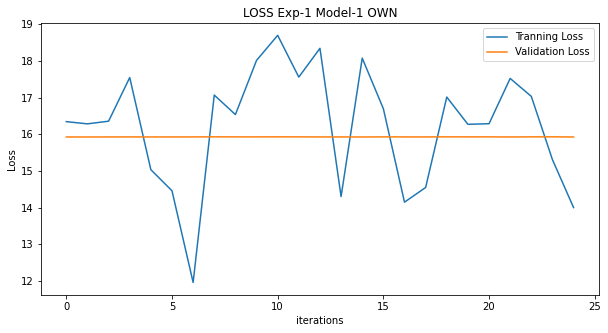

In [146]:
plt.figure(figsize=(10,5))
plt.title("LOSS Exp-1 Model-1 OWN")
plt.plot(_tranning_loss,label="Tranning Loss")
plt.plot(_validation_loss,label="Validation Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

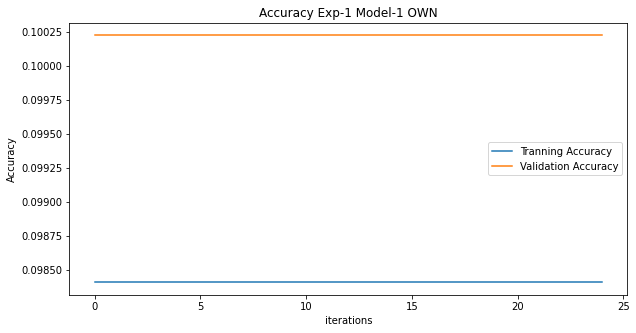

In [147]:
plt.figure(figsize=(10,5))
plt.title("Accuracy Exp-1 Model-1 OWN")
plt.plot(_tranning_acc,label="Tranning Accuracy")
plt.plot(_validation_acc,label="Validation Accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Load test dataset

In [148]:

# IMAGE_SIZE = model['image_size'] ## set image height width to 128x128
# transform = transforms.Compose([
#                                 # transforms.ToPILImage(),

#                                 ## this is only for when model is 1
#                                 transforms.Grayscale(), 
                                
#                                 # transforms.RandomRotation(20,expand=True), ## adding random rotation 20deg
#                                 # torchvision.transforms.ColorJitter(hue=.05, saturation=.05), ## adding color filter
#                                 # transforms.RandomVerticalFlip(), ## adding vertical flip
#                                 # transforms.RandomHorizontalFlip(), ## adding horizontal flip
#                                 transforms.Resize(IMAGE_SIZE),  ## image resize
#                                 transforms.CenterCrop(IMAGE_SIZE), ## image center crop
#                                 transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
#                                 # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                ])
# trainDataset = torchvision.datasets.FashionMNIST(root='./data', 
#                             train=True, 
#                             transform=transform,  # Normalize the image to [0-1] from [0-255]
#                             download=True)

# validDataSet = torchvision.datasets.FashionMNIST(root='./data', 
#                            train=False, 
#                            transform=transform)

# '''
# MAKING DATASET ITERABLE
# '''

# trainloader = torch.utils.data.DataLoader(dataset=trainDataset, 
#                                            batch_size=1, 
#                                            shuffle=True)   # It's better to shuffle the whole training dataset! 

# testloader = torch.utils.data.DataLoader(dataset=validDataSet, 
#                                           batch_size=1, 
#                                           shuffle=False)  

# print("Length of the trainloader:", len(trainloader ) * 1)
# print("Length of the validationloader:", len(testloader ) * 1)

In [149]:
# BATCH_SIZE = 32 ## number of image batch size 
base_dir = '/content/PROCESSED_DATASET_170104019' 
TEST_SIZE = 0.2
IMAGE_SIZE = model['image_size'] ## set image height width to 128x128
transform = transforms.Compose([
                                # transforms.ToPILImage(),

                                ## this is only for when model is 1
                                transforms.Grayscale(), 
                                
                                # transforms.RandomRotation(20,expand=True), ## adding random rotation 20deg
                                # torchvision.transforms.ColorJitter(hue=.05, saturation=.05), ## adding color filter
                                # transforms.RandomVerticalFlip(), ## adding vertical flip
                                # transforms.RandomHorizontalFlip(), ## adding horizontal flip
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE), ## image center crop
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

#load training dataset 
dataset = torchvision.datasets.ImageFolder(base_dir, transform=transform)
n = len(dataset) 
n_test = int(TEST_SIZE * n) # 10% validation
trainDataset, validDataSet = torch.utils.data.random_split(dataset,[n - n_test,n_test]) #random split dataset
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size=1, shuffle=True, pin_memory=True,) 
testloader = torch.utils.data.DataLoader(validDataSet, batch_size=1, shuffle=True, pin_memory=True,) 
print("Length of the trainloader:", len(trainloader ) * 1)
print("Length of the validationloader:", len(testloader ) * 1)

Length of the trainloader: 19439
Length of the validationloader: 4859


In [150]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load model with state

In [151]:
preTrainedModel = model['model_full']
preTrainedModel.load_state_dict( model['model_state'])

<All keys matched successfully>

## Model prediction  

In [152]:
y_true_tensor = torch.tensor([])
y_pred_tensor = torch.tensor([])
preTrainedModel.eval()
for i,(inputs, labels) in enumerate(testloader):

  inputs, labels = inputs.to(device), labels.to(device)
  outputs = preTrainedModel(inputs)
  _, preds = torch.max(outputs, 1)
  y_true_tensor = torch.cat((y_true_tensor,labels))
  y_pred_tensor = torch.cat((y_pred_tensor,preds))
  print(i)
  # break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [153]:
# Convert tensor to list
y_true = y_true_tensor.tolist()
y_pred = y_pred_tensor.tolist()

## Confusion matrix

In [154]:
matrice = confusion_matrix(y_true,y_pred)
matrice

array([[  0,   0,   0,   0,   0,   0,   0,   0, 478,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 485,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 488,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 476,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 507,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 475,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 485,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 481,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 484,   0]])

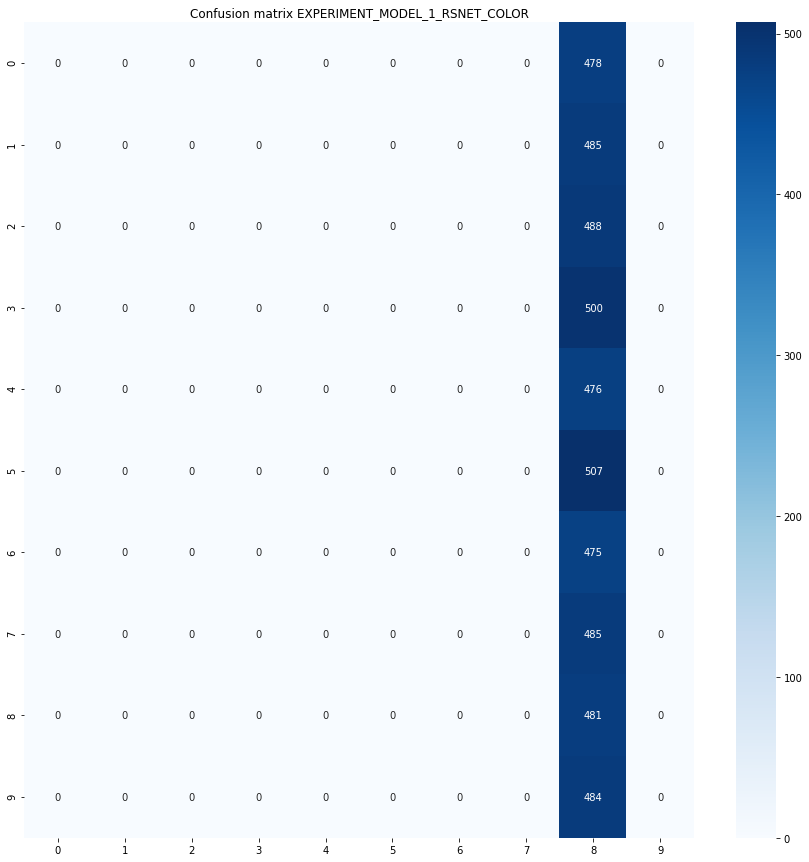

In [155]:

## FOR F-MNIST
# target_names = list(validDataSet.class_to_idx.keys())
# df_cm = pd.DataFrame(matrice,columns=target_names,index=target_names)
# plt.figure(figsize=(15,15))
# sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='g',cmap='Blues',)
# plt.title(f"Confusion matrix {model['MODEL_USED']}")
# plt.show()


## FOR OWN
target_names = list(dataset.class_to_idx.keys())
df_cm = pd.DataFrame(matrice,columns=target_names,index=target_names)
plt.figure(figsize=(15,15))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='g',cmap='Blues',)
plt.title(f"Confusion matrix {model['MODEL_USED']}")
plt.show()

## Classification Report `recision,  recall,  f1-score`

In [156]:
## FOR FNIMST
# target_names = list(validDataSet.class_to_idx.keys())
# classify_report = classification_report(y_true, y_pred, target_names=target_names)
# print(classify_report)


## FOR OWN
target_names = list(dataset.class_to_idx.keys())
classify_report = classification_report(y_true, y_pred, target_names=target_names)
print(classify_report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       478
           1       0.00      0.00      0.00       485
           2       0.00      0.00      0.00       488
           3       0.00      0.00      0.00       500
           4       0.00      0.00      0.00       476
           5       0.00      0.00      0.00       507
           6       0.00      0.00      0.00       475
           7       0.00      0.00      0.00       485
           8       0.10      1.00      0.18       481
           9       0.00      0.00      0.00       484

    accuracy                           0.10      4859
   macro avg       0.01      0.10      0.02      4859
weighted avg       0.01      0.10      0.02      4859

